C:\Users\User_1\AppData\Local\Temp\ipykernel_31144\517291877.py:126: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.observation_space = spaces.Box(low=0, high=3, shape=(grid_size, grid_size), dtype=np.int)


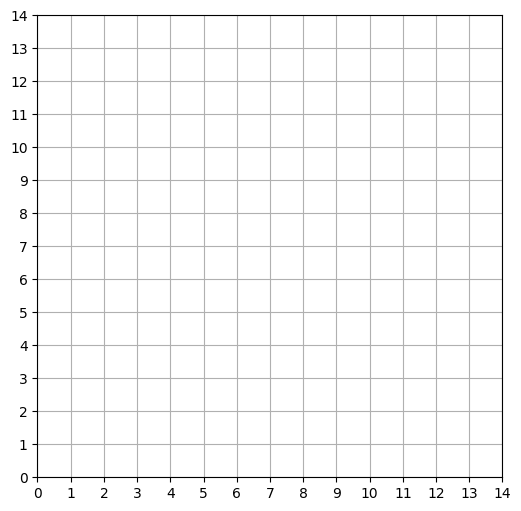

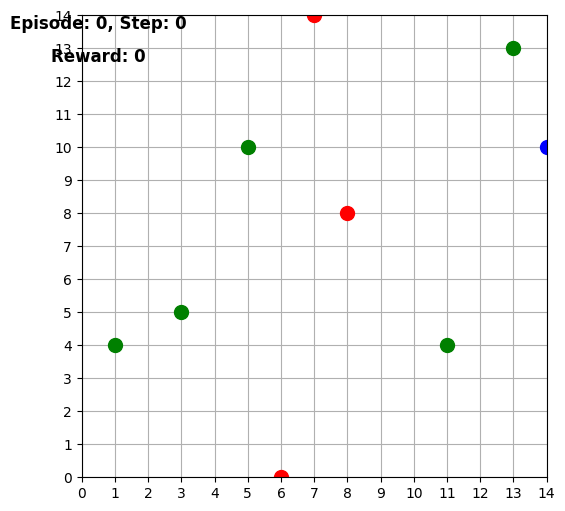

Episode 1 finished


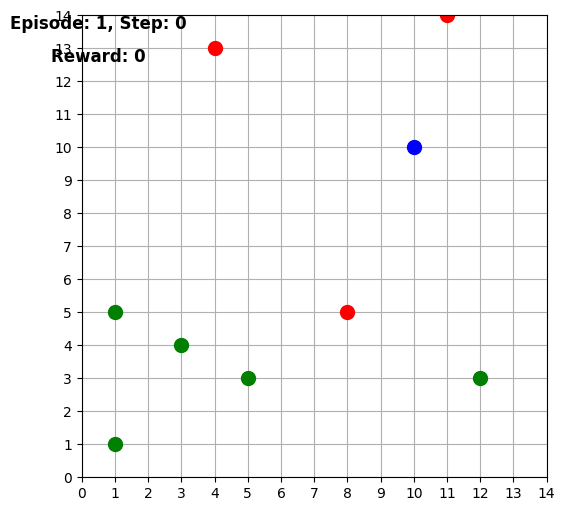

Episode 2 finished


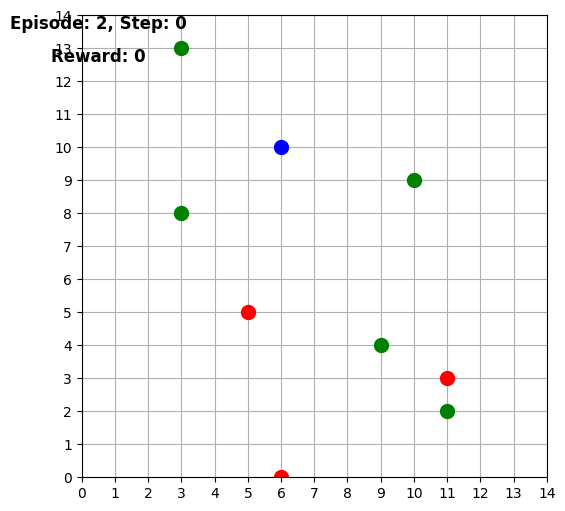

KeyboardInterrupt: 

In [53]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import time

# -----------------------------
# Q-Network for DQN Agent
# -----------------------------
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# -----------------------------
# Replay Buffer
# -----------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)


# -----------------------------
# DQN Agent
# -----------------------------
class DQNAgent:
    def __init__(self, action_space, state_space, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.1, 
                 epsilon_decay=0.995, batch_size=64, buffer_size=10000):
        self.action_space = action_space  # usually an integer count
        self.state_space = state_space    # dimensionality of flattened state
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.q_network = QNetwork(state_space, action_space)
        self.target_network = QNetwork(state_space, action_space)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_size)

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_space)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state)
        return torch.argmax(q_values).item()

    def train(self):
        if self.buffer.size() < self.batch_size:
            return

        batch = self.buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones)

        # Compute Q values from current network
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        # Compute target Q values from target network
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards.unsqueeze(1) + self.gamma * next_q_values * (1 - dones.unsqueeze(1))

        loss = F.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# -------------------------------------------
# Collect & Avoid Environment (gym.Env subclass)
# -------------------------------------------

class CollectAvoidEnv(gym.Env):
    def __init__(self, grid_size=15, num_rewards=5, num_enemies=3):
        super(CollectAvoidEnv, self).__init__()

        self.grid_size = grid_size
        self.num_rewards = num_rewards
        self.num_enemies = num_enemies
        self.reward_positions = []
        self.enemy_positions = []
        self.agent_pos = None
        
        # Action space: 5 discrete actions
        self.action_space = spaces.Discrete(5)  # 5 actions: stay, up, down, left, right
        
        # Observation space: grid_size x grid_size grid
        self.observation_space = spaces.Box(low=0, high=3, shape=(grid_size, grid_size), dtype=np.int)

        self.reset()  # Initialize the environment state and plot
        
    def reset(self):
        self.reward_positions = [self._random_empty_cell([]) for _ in range(self.num_rewards)]
        self.enemy_positions = [self._random_empty_cell(self.reward_positions) for _ in range(self.num_enemies)]
        self.agent_pos = self._random_empty_cell(self.reward_positions + self.enemy_positions)
        
        # Initialize the plot and axis only once
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.ax.set_xlim(0, self.grid_size - 1)
        self.ax.set_ylim(0, self.grid_size - 1)
        self.ax.set_xticks(range(self.grid_size))
        self.ax.set_yticks(range(self.grid_size))
        self.ax.grid(True)

        return self._get_state()
        
    def render(self, episode, step, reward=None):
        # Clear the previous points from the figure but don't recreate the entire plot
        self.ax.clear()
        self.ax.set_xlim(0, self.grid_size - 1)
        self.ax.set_ylim(0, self.grid_size - 1)
        self.ax.set_xticks(range(self.grid_size))
        self.ax.set_yticks(range(self.grid_size))
        self.ax.grid(True)

        # Plot agent, rewards, and enemies
        self.ax.plot(self.agent_pos[0], self.agent_pos[1], 'bo', markersize=10)  # Agent as blue circle
        for r_pos in self.reward_positions:
            self.ax.plot(r_pos[0], r_pos[1], 'go', markersize=10)  # Reward as green circle
        for e_pos in self.enemy_positions:
            self.ax.plot(e_pos[0], e_pos[1], 'ro', markersize=10)  # Enemy as red circle
        
        # Display the episode, step, and reward on the plot
        self.ax.text(0.5, self.grid_size - 1, f'Episode: {episode}, Step: {step}', horizontalalignment='center', verticalalignment='top', fontsize=12, color='black', weight='bold')
        if reward is not None:
            self.ax.text(0.5, self.grid_size - 2, f'Reward: {reward}', horizontalalignment='center', verticalalignment='top', fontsize=12, color='black', weight='bold')

        # Pause to update the plot and slow down the environment
        plt.pause(0.1)  # Adjust this value for desired delay
        time.sleep(0.1)  # Add additional sleep to slow down the simulation further

    def step(self, action, episode, step):
        # Define the logic for agent movement based on the action taken
        if action == 0:  # stay
            new_pos = self.agent_pos
        elif action == 1:  # up
            new_pos = (max(self.agent_pos[0] - 1, 0), self.agent_pos[1])
        elif action == 2:  # down
            new_pos = (min(self.agent_pos[0] + 1, self.grid_size - 1), self.agent_pos[1])
        elif action == 3:  # left
            new_pos = (self.agent_pos[0], max(self.agent_pos[1] - 1, 0))
        elif action == 4:  # right
            new_pos = (self.agent_pos[0], min(self.agent_pos[1] + 1, self.grid_size - 1))
        
        self.agent_pos = new_pos
        self.reward_positions = [self._random_empty_cell([]) for _ in range(self.num_rewards)]  # Random rewards
        self.enemy_positions = [self._random_empty_cell(self.reward_positions) for _ in range(self.num_enemies)]  # Random enemies

        # Check if the agent collected a reward or encountered an enemy
        reward = 0
        done = False
        if self.agent_pos in self.reward_positions:
            reward = 1  # Reward collected
            self.reward_positions.remove(self.agent_pos)
        if self.agent_pos in self.enemy_positions:
            done = True  # Game over if the agent encounters an enemy
        
        self.render(episode, step, reward)  # Update the plot with reward, episode, and step
        return self._get_state(), reward, done, {}

    def _get_state(self):
        state = np.zeros((self.grid_size, self.grid_size))
        state[self.agent_pos] = 1  # Mark the agent's position
        for r_pos in self.reward_positions:
            state[r_pos] = 2  # Mark rewards
        for e_pos in self.enemy_positions:
            state[e_pos] = 3  # Mark enemies
        return state.flatten()

    def _random_empty_cell(self, excluded_cells):
        while True:
            cell = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if cell not in excluded_cells:
                return cell


# -------------------------------------------
# Train the Agent
# -------------------------------------------
env = CollectAvoidEnv()
agent = DQNAgent(env.action_space.n, np.prod(env.observation_space.shape))

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    step = 0
    while not done:
        action = agent.act(state)  # Get action from your agent
        next_state, reward, done, _ = env.step(action, episode, step)
        step += 1
        agent.buffer.add((state.flatten(), action, reward, next_state.flatten(), float(done)))
        agent.train()
    if episode % 10 == 0:
        agent.update_target_network()
    print(f"Episode {episode + 1} finished")


env.close()


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gym
from gym import spaces
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.nn import functional as F

In [28]:
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)


In [29]:
class DQNAgent:
    def __init__(self, action_space, state_space, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, batch_size=64, buffer_size=10000):
        self.action_space = action_space
        self.state_space = state_space
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.q_network = QNetwork(state_space, action_space)
        self.target_network = QNetwork(state_space, action_space)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_size)

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_space)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state)
        return torch.argmax(q_values).item()

    def train(self):
        if self.buffer.size() < self.batch_size:
            return

        batch = self.buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Q-values from the current Q-network
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Q-values from the target Q-network
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards.unsqueeze(1) + (self.gamma * next_q_values * (1 - dones.unsqueeze(1)))

        # Compute the loss
        loss = F.mse_loss(q_values, target_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [30]:
class CollectAvoidEnv(gym.Env):
    def __init__(self):
        super(CollectAvoidEnv, self).__init__()
        self.grid_size = 15
        self.max_steps = 100
        self.num_rewards = random.randint(5, 7)
        self.num_enemies = random.randint(2, 3)

        self.action_space = spaces.Discrete(5)  # [stay, up, down, left, right]
        self.observation_space = spaces.Box(low=0, high=3, shape=(self.grid_size, self.grid_size), dtype=np.uint8)

        # UI setup
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.img = None

        # Initialize total reward here
        self.total_reward = 0.0

    def reset(self):
        # Initialize all positions
        self.reward_positions = [self._random_empty_cell([])] * self.num_rewards
        self.enemy_positions = [self._random_empty_cell(self.reward_positions)] * self.num_enemies
        self.agent_pos = self._random_empty_cell(self.reward_positions + self.enemy_positions)  # Now safely initialize agent position
        self.steps = 0
        self.total_reward = 0  # Reset the total reward for the new episode
        self.done = False
        return self._get_observation()

    def step(self, action):
        if self.done:
            return self._get_observation(), 0.0, True, {}

        # Move agent
        self.agent_pos = self._move(self.agent_pos, action)

        # Move enemies (mostly chase)
        new_enemies = []
        for pos in self.enemy_positions:
            if random.random() < 0.8:
                move = self._chase_move(pos, self.agent_pos)
            else:
                move = random.randint(0, 4)
            new_enemies.append(self._move(pos, move))
        self.enemy_positions = new_enemies

        # Move rewards randomly
        self.reward_positions = [self._move(pos, random.randint(0, 4)) for pos in self.reward_positions]

        # Reward calculation
        reward = 0.0
        for reward_pos in self.reward_positions:
            if np.array_equal(self.agent_pos, reward_pos):  # Use np.array_equal for comparison
                reward += 10.0
                self.reward_positions.remove(reward_pos)  # Remove the collected reward
                break  # Prevent modifying the list during iteration

        # Check if agent collides with any enemy
        for enemy_pos in self.enemy_positions:
            if np.array_equal(self.agent_pos, enemy_pos):  # Use np.array_equal for comparison
                reward -= 20.0
                self.done = True
                break

        self.total_reward += reward
        self.steps += 1
        if self.steps >= self.max_steps:
            self.done = True

        return self._get_observation(), reward, self.done, {}

    def render(self):
        grid = self._get_observation()

        if self.img is None:
            self.img = self.ax.imshow(grid, cmap='viridis', interpolation='nearest', vmin=0, vmax=3)
        else:
            self.img.set_data(grid)
        self.ax.set_title(f"Step: {self.steps} | Total Reward: {self.total_reward:.2f}")
        clear_output(wait=True)
        display(self.fig)

    def close(self):
        plt.close()


AttributeError: 'CollectAvoidEnv' object has no attribute '_random_empty_cell'

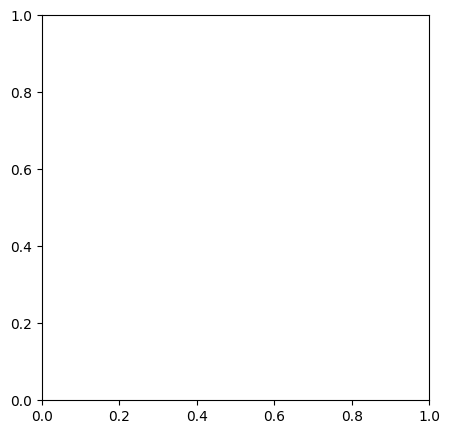

In [31]:
env = CollectAvoidEnv()
agent = DQNAgent(action_space=5, state_space=env.grid_size**2, lr=0.001)

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state.flatten())  # Flatten state to pass to the DQN agent
        next_state, reward, done, _ = env.step(action)
        
        agent.buffer.add((state.flatten(), action, reward, next_state.flatten(), done))
        agent.train()

        state = next_state

    agent.update_target_network()  # Periodically update the target network

    if episode % 50 == 0:
        print(f"Episode {episode} | Total Reward: {env.total_reward} | Epsilon: {agent.epsilon:.4f}")
    env.render()

